# Cloud classification using pixel type labels from FSE

### Classes:
- clear, 0
- cloud, 1
- haze, 2
- shadow, 3

53,498 total point samples were collected across the ten Sentinel-2 bands without any scaling applied

In [3]:
import os
import sys

# This should be '/home/croptype/bin/python'
print(sys.executable)

/home/croptype/bin/python


In [5]:
import pandas as pd
import pickle
import numpy as np
import itertools
from matplotlib import pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, f1_score

import pylab as pl
import time
from IPython import display

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
data_dir = '/home/data/clouds/'
data_fname = 'clean_samples.csv'

data_path = os.path.join(data_dir, data_fname)

In [5]:
df = pd.read_csv(data_path)

df_sub = df[['poly_id', 'pixel_id', 'class', 'blue', 'green', 'red', 'rded1', 
             'rded2', 'rded3', 'nir', 'rded4', 'swir1', 'swir2']]

In [6]:
# Add a column class_num that takes the class and gives it a categorial representation
# clear -> 0, cloud -> 1, haze -> 2, shadow -> 3
df_sub['class'] = pd.Categorical(df_sub['class'])
df_sub['class_num'] = df_sub['class'].astype('category').cat.codes

In [7]:
# Split data according to poly_ID, which contain 5 pixels each
X = df_sub
groups = df_sub['poly_id']

train_inds, test_inds = next(GroupShuffleSplit(n_splits=3, test_size=0.1, train_size=0.8).split(X, groups=groups))

val_inds = []
for i in range(X.shape[0]):
    if i not in train_inds and i not in test_inds:
        val_inds.append(i)
        
val_inds = np.asarray(val_inds)

In [8]:
# Shuffle dataset by shuffling train, val, and test indices
np.random.seed(1234)

np.random.shuffle(train_inds)
np.random.shuffle(val_inds)
np.random.shuffle(test_inds)

# Check if shuffled
print(train_inds)
print(val_inds)
print(test_inds)

[26050 29591 12207 ... 29834 42816 34339]
[28616 24938  7809 ... 10557 31419 17854]
[37494 20064 48817 ... 19315 28593 35623]


In [9]:
X_train, y_train = X.values[train_inds,3:-1], X.values[train_inds,-1].astype(int)
X_val, y_val = X.values[val_inds, 3:-1], X.values[val_inds, -1].astype(int)
X_test, y_test = X.values[test_inds, 3:-1], X.values[test_inds, -1].astype(int)

In [10]:
# Define the Random Forest classifier
# n_estimators - more trees, less likely to overfit?
# max_features - the smaller, the less likely to overfit
# max_depth - reduce to reduce complexity 
# min_samples_leaf - set > 1?

model = RandomForestClassifier(n_jobs=-1, n_estimators=50)

# Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
# Get the predictions from the model
train_pred_lbls = model.predict(X_train)
val_pred_lbls = model.predict(X_val)
test_pred_lbls = model.predict(X_test)

In [12]:
# Finished classifying. Get the accuracy scores and f1-scores
tr_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

print('train scores: ', tr_score)
print('val scores: ', val_score)
print('test scores: {}\n'.format(test_score))

tr_f1 = f1_score(y_train, train_pred_lbls, average='micro')
val_f1 = f1_score(y_val, val_pred_lbls, average='micro')
test_f1 = f1_score(y_test, test_pred_lbls, average='micro')

print('train f-1 score: ', tr_f1)
print('val f-1 score: ', val_f1)
print('test f-1 score: ', test_f1)

train scores:  0.9997897196261682
val scores:  0.8520389075944631
test scores: 0.84398355754858

train f-1 score:  0.9997897196261682
val f-1 score:  0.8520389075944631
test f-1 score:  0.84398355754858


In [13]:
# Visualize the results
train_kappa = cohen_kappa_score(y_train, train_pred_lbls)
train_cm = confusion_matrix(y_train, train_pred_lbls)

val_kappa = cohen_kappa_score(y_val, val_pred_lbls)
val_cm = confusion_matrix(y_val, val_pred_lbls)

test_kappa = cohen_kappa_score(y_test, test_pred_lbls)
test_cm = confusion_matrix(y_test, test_pred_lbls)

print('Train kappa: ', train_kappa)
print('Validation kappa: ', val_kappa)
print('Test kappa: ', test_kappa)

Train kappa:  0.9997188406909159
Validation kappa:  0.8023091390028899
Test kappa:  0.7904973641293188


Confusion matrix, without normalization


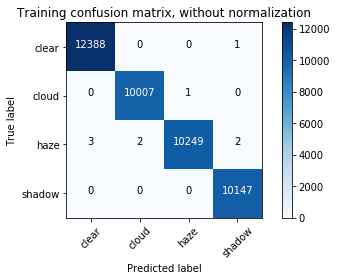

Normalized confusion matrix


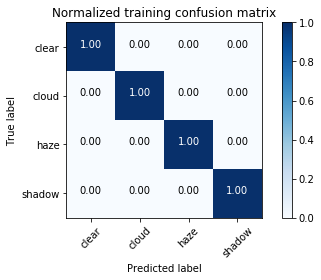

Confusion matrix, without normalization


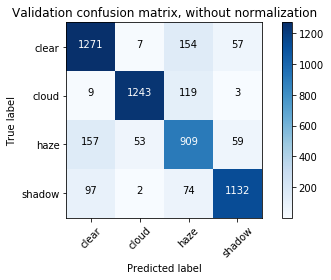

Normalized confusion matrix


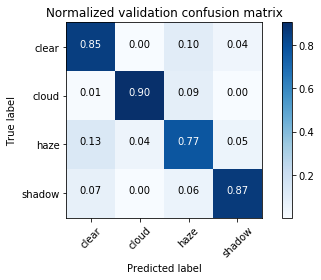

Confusion matrix, without normalization


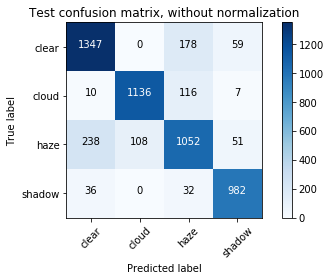

Normalized confusion matrix


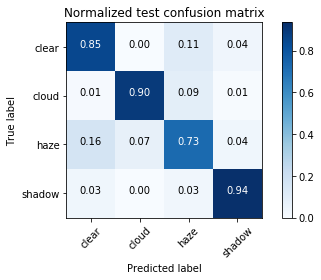

In [14]:
class_names = ['clear', 'cloud', 'haze', 'shadow']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(train_cm, classes=class_names,
                      title='Training confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(train_cm, classes=class_names, normalize=True,
                      title='Normalized training confusion matrix')
plt.show()

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(val_cm, classes=class_names,
                      title='Validation confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(val_cm, classes=class_names, normalize=True,
                      title='Normalized validation confusion matrix')
plt.show()

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_cm, classes=class_names,
                      title='Test confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_cm, classes=class_names, normalize=True,
                      title='Normalized test confusion matrix')
plt.show()

In [7]:
def s2_format(s2):
    s2_bgr = s2[0:3, :, :]
    s2_bgr = np.transpose(s2_bgr, (1, 2, 0))

    s2_rgb = np.zeros_like(s2_bgr)
    s2_rgb[:,:,0] = s2_bgr[:,:,2]
    s2_rgb[:,:,1] = s2_bgr[:,:,1]
    s2_rgb[:,:,2] = s2_bgr[:,:,0]
    
    # normalize using bounds from QGIS
    minval = 1100
    maxval = 2100

    s2_rgb[:,:,0] = (s2_rgb[:,:,0] - minval) / (maxval - minval)
    s2_rgb[:,:,1] = (s2_rgb[:,:,1] - minval) / (maxval - minval)
    s2_rgb[:,:,2] = (s2_rgb[:,:,2] - minval) / (maxval - minval)  
    return s2_rgb

In [16]:
def plt_legend():
    plt.figure()
    plt.subplot(141)
    plt.title('clear')
    plt.imshow(np.zeros((10,10)), vmin=0, vmax=3)
    plt.subplot(142)
    plt.title('cloud')
    plt.imshow(np.ones((10,10)), vmin=0, vmax=3)
    plt.subplot(143)
    plt.title('haze')
    plt.imshow(np.ones((10,10))*2, vmin=0, vmax=3)
    plt.subplot(144)
    plt.title('shadow')
    plt.imshow(np.ones((10,10))*3, vmin=0, vmax=3)

In [17]:
def show_video(img_array):
    for i in range(img_array.shape[0]):
        pl.imshow(img_array[i])
        pl.title('Time Number: ' + str(i))
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(1.0)

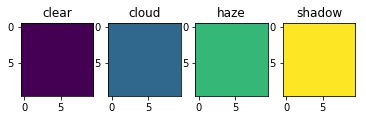

In [18]:
plt_legend()

In [8]:
# Test on some images and create cloud masks 
#data_dir = '/home/data/small/val/s2'
data_dir = '/home/data/Ghana/s2_64x64_npy/'
data_fnames = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.npy')]

mask_dir = os.path.join(data_dir, 'cloud_masks')
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)

for fname in data_fnames:
    arr = np.load(fname)
    mask_arr = np.zeros((arr.shape[1], arr.shape[2], arr.shape[3]))
    
    for timestamp in range(arr.shape[3]):
        cur_img = arr[:,:,:,timestamp]
        disp_img = s2_format(cur_img)
        cur_img = np.transpose(cur_img, (1, 2, 0))
        cur_img = np.reshape(cur_img, [-1, 10])
        cur_pred = model.predict(cur_img)
        cur_pred = np.reshape(cur_pred, (64, 64))
        
        mask_arr[:,:,timestamp] = cur_pred
        
        ##plt.figure()
        #plt.subplot(121)
        #plt.imshow(cur_pred, vmin=0, vmax=3)
        #plt.subplot(122)
        #plt.imshow(disp_img)
        ##plt.show()
        
        #display.clear_output(wait=True)
        #display.display(pl.gcf())
        #time.sleep(0.5)
    
    out_fname = os.path.join(mask_dir, fname.split('/')[-1].split('.')[0]+'_mask.npy')
    #print("Mask for {} saved to {}".format(fname, out_fname))
    np.save(out_fname, mask_arr)
        

NameError: name 'model' is not defined